# Cornell Movie - Dialogs Corpus

This corpus contains a large metadata-rich collection of fictional conversations extracted from raw movie scripts. We use this dataset to build a simple chatbot using [Neural Conversational Model](https://arxiv.org/abs/1506.05869). 

---

According to the dataset [website](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html), this dataset contains:

* 220,579 conversational exchanges between 10,292 pairs of movie characters
* involves 9,035 characters from 617 movies
* in total 304,713 utterances
* movie metadata included:
    - genres

    - release year

    - IMDB rating

    - number of IMDB votes

    - IMDB rating

* character metadata included:
    - gender (for 3,774 characters)

    - position on movie credits (3,321 characters)

We only use the conversational exchanges to build a simple chatbot.

---

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import seaborn as sns
import plotly.express as px
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

First, we load the data and print the first 10 examples to get an insight of the dataset

In [2]:
corpus_name = "cornell movie-dialogs corpus"
corpus = os.path.join("data", corpus_name)

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(corpus, "movie_lines.txt"))

b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"
b'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow\n'
b"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.\n"
b'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No\n'
b'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n'
b'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?\n'


---

Then, we define functions to load the lines and reformate them by splitting on the delimiter of the dataset which is `+++$+++`. After that, we load the conversations and pair them in a question-answer pairs

In [3]:
# Splits each line of the file into a dictionary of fields
def loadLines(fileName, fields):
    lines = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            lineObj = {}
            for i, field in enumerate(fields):
                lineObj[field] = values[i]
            lines[lineObj['lineID']] = lineObj
    return lines


# Groups fields of lines from `loadLines` into conversations based on *movie_conversations.txt*
def loadConversations(fileName, lines, fields):
    conversations = []
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            convObj = {}
            for i, field in enumerate(fields):
                convObj[field] = values[i]
            # Convert string to list (convObj["utteranceIDs"] == "['L598485', 'L598486', ...]")
            utterance_id_pattern = re.compile('L[0-9]+')
            lineIds = utterance_id_pattern.findall(convObj["utteranceIDs"])
            # Reassemble lines
            convObj["lines"] = []
            for lineId in lineIds:
                convObj["lines"].append(lines[lineId])
            conversations.append(convObj)
    return conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations:
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

We use the previously defined functions and output some question-answer pairs.

In [4]:
# Define path to new file
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict, conversations list, and field ids
lines = {}
conversations = []
MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]
MOVIE_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"]

# Load lines and process conversations
print("\nProcessing corpus...")
lines = loadLines(os.path.join(corpus, "movie_lines.txt"), MOVIE_LINES_FIELDS)
print("\nLoading conversations...")
conversations = loadConversations(os.path.join(corpus, "movie_conversations.txt"),
                                  lines, MOVIE_CONVERSATIONS_FIELDS)

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# Print a sample of lines
print("\nSample lines from file:")
printLines(datafile)


Processing corpus...

Loading conversations...

Writing newly formatted file...

Sample lines from file:
b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\n"
b"Cameron.\tThe thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\n"
b"The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't dat

---

We define a vocabulary class. This class contains some information about the number of words, the number of each word, mapping between words and numbers and vice versa. We also define the padding tokens to make our sentences of equal length

In [5]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [6]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs
voc, pairs = readVocs(datafile, corpus_name)

Reading lines...


---

Now we get some insight about the length of every question and answer. More specifically, we visualize the length of the maximum and minimum 10 questions and answers.

In [7]:
questions_length = sorted([len(p[0].split(' ')) for p in pairs])
Answers_length = sorted([len(p[1].split(' ')) for p in pairs])

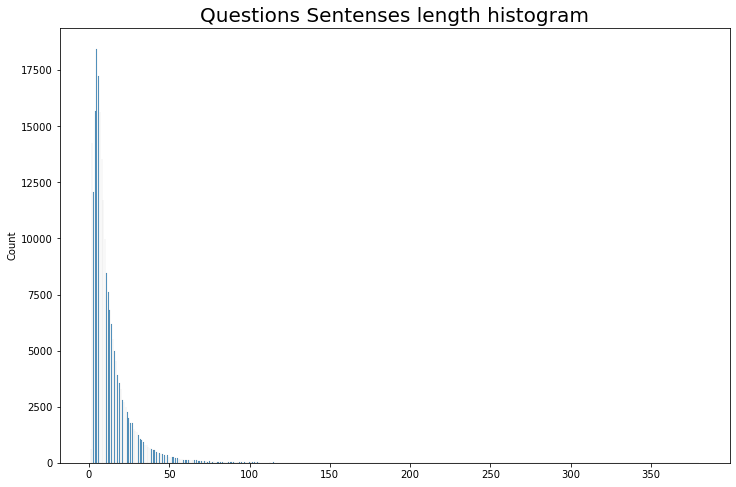

In [8]:
colors = sns.color_palette("spring", 20)
plt.figure(figsize=(12,8))
ax = sns.histplot(questions_length)
#ax.set_xlabel(xlabel='Words', fontsize=16)
#ax.set_ylabel(ylabel='Word Count', fontsize=16)
ax.set_title(label='Questions Sentenses length histogram', fontsize=20)
#ax.set_yticklabels(labels = publishers, fontsize=14)
plt.show();

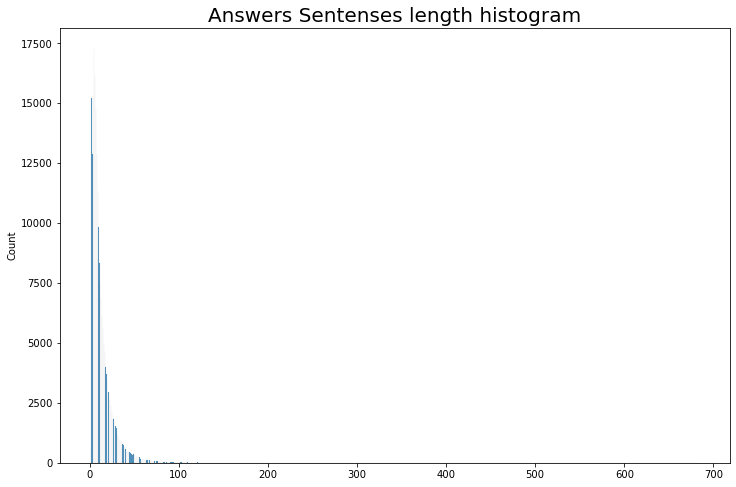

In [9]:
colors = sns.color_palette("spring", 20)
plt.figure(figsize=(12,8))
ax = sns.histplot(Answers_length)
#ax.set_xlabel(xlabel='Words', fontsize=16)
#ax.set_ylabel(ylabel='Word Count', fontsize=16)
ax.set_title(label='Answers Sentenses length histogram', fontsize=20)
#ax.set_yticklabels(labels = publishers, fontsize=14)
plt.show();

From these plots, it's obvious that we need to restrict words length in both questions and answers. We choose a limit length of 10 for both

In [10]:
MAX_LENGTH = 10  # Maximum sentence length to consider

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64271 sentence pairs
Counting words...
Counted words: 18008

pairs:
['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']


As we can see, we habe 18008 words in our corpus. So, we try to clean these words.

In [11]:
words_count = voc.word2count
words_count = {k: v for k, v in sorted(words_count.items(), key=lambda item: item[1], reverse=True)}
print("Printing highest 10 words counts")
i = 0
for key, value in words_count.items():
    if(i >= 10):
        break
    print(key, value)
    i += 1

Printing highest 10 words counts
. 104124
? 43942
you 29248
i 22076
what 12633
s 12452
it 11523
! 11227
the 10739
a 8579


In [12]:
words_count_hist = np.array(list(words_count.values()))
words_hist = np.array(list(words_count.keys()))
words_count_hist, words_hist

(array([104124,  43942,  29248, ...,      1,      1,      1]),
 array(['.', '?', 'you', ..., 'lorj', 'stuart', 'artillery'], dtype='<U27'))

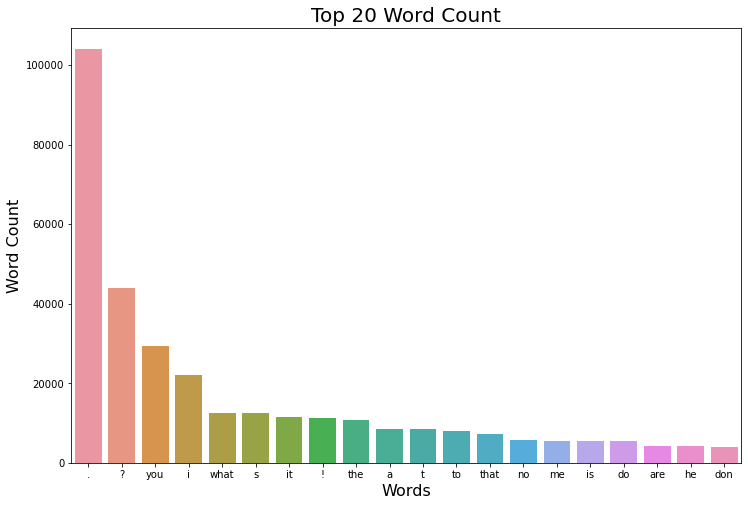

In [13]:
colors = sns.color_palette("spring", 20)
plt.figure(figsize=(12,8))
ax = sns.barplot(y = words_count_hist[:20] , x = words_hist[:20])
ax.set_xlabel(xlabel='Words', fontsize=16)
ax.set_ylabel(ylabel='Word Count', fontsize=16)
ax.set_title(label='Top 20 Word Count', fontsize=20)
#ax.set_yticklabels(labels = publishers, fontsize=14)
plt.show();

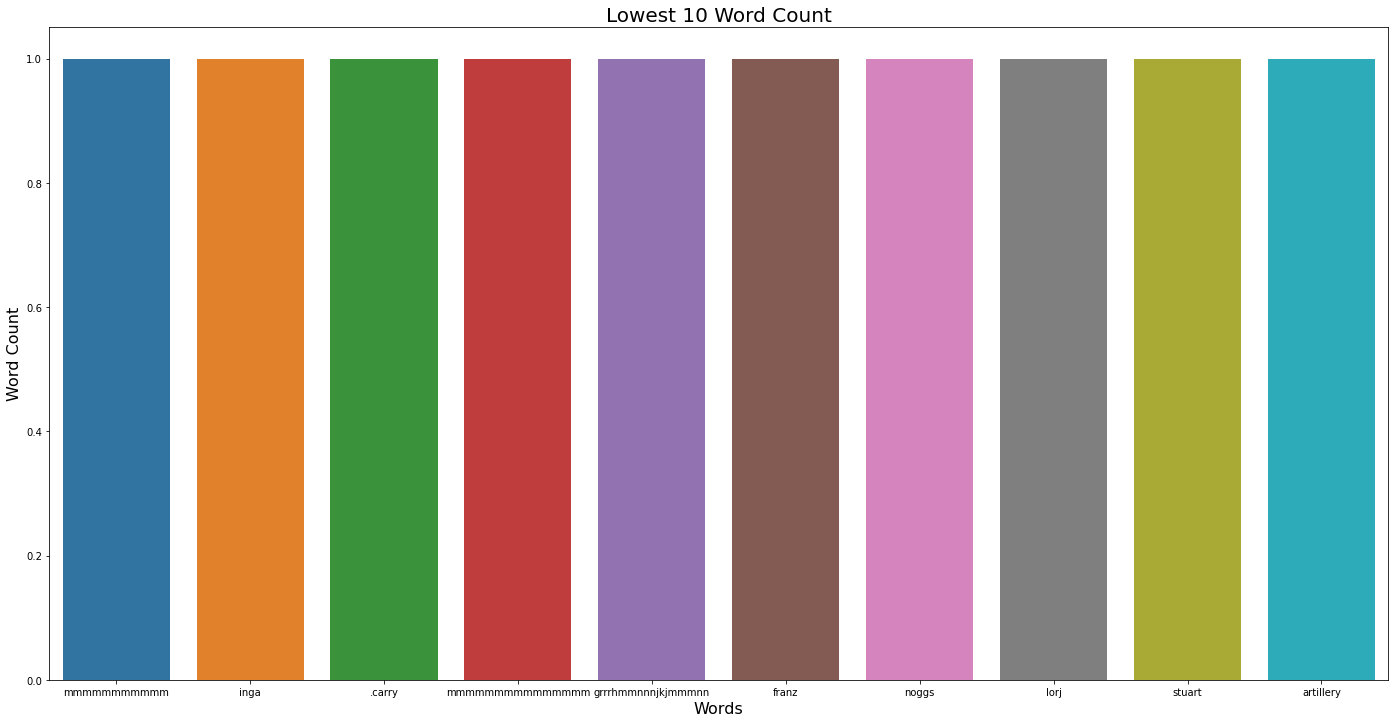

Lowest words in terms of count are:['mmmmmmmmmmm' 'inga' '.carry' 'mmmmmmmmmmmmmmm' 'grrrhmmnnnjkjmmmnn'
 'franz' 'noggs' 'lorj' 'stuart' 'artillery']


In [14]:
plt.figure(figsize=(24,12))
ax = sns.barplot(y = words_count_hist[-10:] , x = words_hist[-10:])
ax.set_xlabel(xlabel='Words', fontsize=16)
ax.set_ylabel(ylabel='Word Count', fontsize=16)
ax.set_title(label='Lowest 10 Word Count', fontsize=20)
#ax.set_yticklabels(labels = publishers, fontsize=14)
plt.show();
print("Lowest words in terms of count are:{}".format(words_hist[-10:]))

Thus it's obvious that words below some certain threshold should be removed as they will most likely be wrong words 

In [15]:
MIN_COUNT = 5    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 5127 / 18005 = 0.2848
Trimmed from 64271 pairs to 47075, 0.7324 of total


---

## Data Preparation For Training

Now we prepare our dataset before training. We convert our sentenses to tensors and make binary masks for the data to be used later in the training process

In [16]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[  49,   27,   76,   12, 1546],
        [  91,   88,  114, 2152,    6],
        [   7,  383,   75,    4,    2],
        [ 122,   97,    6,    2,    0],
        [  40,   52,    2,    0,    0],
        [  46,  664,    0,    0,    0],
        [   6,    4,    0,    0,    0],
        [   2,    2,    0,    0,    0]])
lengths: tensor([8, 8, 5, 4, 3])
target_variable: tensor([[  25,   49,   75,   27,  309],
        [1099,  664,   37,   88,  641],
        [  25,    6,   82,  935,    6],
        [ 306,    2,    4,  503,    2],
        [   4,    0,    2,  465,    0],
        [   2,    0,    0,    4,    0],
        [   0,    0,    0,    2,    0]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True, False,  True,  True, False],
        [ True, False, False,  True, False],
        [False, False, False,  True, False]])
max_target

---

## Defining the Model

The model uses an “encoder-decoder” framework, mapping an arbitrarily long input sequence to an arbitrarily long output sequence with an intermediate encoded state. 

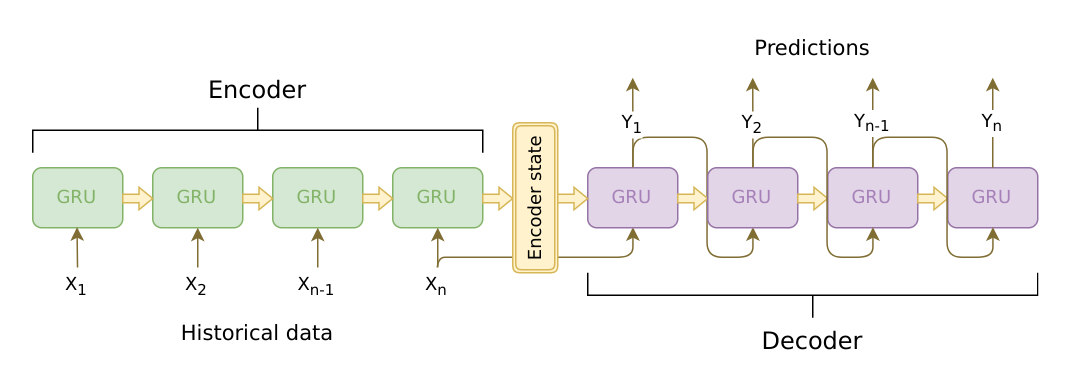

The encoder in our architecture iterates through the input sequency and outputs a `hidden state` vector which captures sequential information and another `output` vector. The `hidden state` vector from the previous time step $h_t$ is passed to the network at the next time step $h_{t + 1}$. The output vector is recorder at each time step to be given to the decoder later for decoding. 

For our encoder, we use a bidirectional GRU architecture to encode the input

In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

For the decoder, it uses hidden states similar to the encoder and the encoder output vectors to generate a sequence of words. This sequence terminates with the `EOS` token that was previously defined.

We also utilize attention mechanisms to combat information loss in long sequences. That is we allow the decoder to focus on certain parts only of the encoder output. The weights generated that allos the decoder to focus on these certain outputs are calculated using the decoder `hidden state`

First, we define out attention layer based on [Luong et al.](https://arxiv.org/abs/1508.04025) proposition

In [18]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

Then, we define the actual decoder

In [19]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

---

Now that we have implemented our encoder and decoder. It's time to define our loss function. Since we are using variable length input sentences, we use a masked loss to take into account only the actual words in the original sentense. We define our masked loss to make only actual words in the sentense guide our model

In [20]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

---

Then, we define our training function. First, we define the `train` function to do only a single training iteration. It's also worth noting that gradient clipping is used to restrict the gradient exploding from affecting our training process.

In [21]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

Finally, we define the trainIters `function` to run mutiple iterations of our training.

In [22]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

---

Next, we define the evaluation functions for our model. We use a greedy decoder. That is we use the highest probaility word outputted from the decoder.

First, we define the greedy search decoder

In [23]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

---

Then, we define the evaluation function. It's worth noting that the evaluation functions converts the indices of the words to the actual words

In [24]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to('cpu')
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

---

Finally, we run the our model. We also save the model to `cb_model`

In [25]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


Run Training

In [26]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 5000
print_every = 1
save_every = 500

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have cuda, configure cuda to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1; Percent complete: 0.0%; Average loss: 8.5554
Iteration: 2; Percent complete: 0.0%; Average loss: 8.4404
Iteration: 3; Percent complete: 0.1%; Average loss: 8.2332
Iteration: 4; Percent complete: 0.1%; Average loss: 7.8608
Iteration: 5; Percent complete: 0.1%; Average loss: 7.4564
Iteration: 6; Percent complete: 0.1%; Average loss: 7.0649
Iteration: 7; Percent complete: 0.1%; Average loss: 6.5012
Iteration: 8; Percent complete: 0.2%; Average loss: 6.5550
Iteration: 9; Percent complete: 0.2%; Average loss: 6.3044
Iteration: 10; Percent complete: 0.2%; Average loss: 6.5546
Iteration: 11; Percent complete: 0.2%; Average loss: 5.8023
Iteration: 12; Percent complete: 0.2%; Average loss: 5.6908
Iteration: 13; Percent complete: 0.3%; Average loss: 5.4211
Iteration: 14; Percent complete: 0.3%; Average loss: 5.5603
Iteration: 15; Percent complete: 0.3%; Average loss: 5.2168
Iteration: 16; Percent complete: 0.3%

Iteration: 136; Percent complete: 2.7%; Average loss: 4.2735
Iteration: 137; Percent complete: 2.7%; Average loss: 4.2970
Iteration: 138; Percent complete: 2.8%; Average loss: 4.2384
Iteration: 139; Percent complete: 2.8%; Average loss: 4.2463
Iteration: 140; Percent complete: 2.8%; Average loss: 4.4146
Iteration: 141; Percent complete: 2.8%; Average loss: 4.1768
Iteration: 142; Percent complete: 2.8%; Average loss: 3.9950
Iteration: 143; Percent complete: 2.9%; Average loss: 4.0631
Iteration: 144; Percent complete: 2.9%; Average loss: 4.1793
Iteration: 145; Percent complete: 2.9%; Average loss: 4.2083
Iteration: 146; Percent complete: 2.9%; Average loss: 4.0337
Iteration: 147; Percent complete: 2.9%; Average loss: 4.4611
Iteration: 148; Percent complete: 3.0%; Average loss: 4.2125
Iteration: 149; Percent complete: 3.0%; Average loss: 4.0586
Iteration: 150; Percent complete: 3.0%; Average loss: 4.0736
Iteration: 151; Percent complete: 3.0%; Average loss: 3.8346
Iteration: 152; Percent 

Iteration: 271; Percent complete: 5.4%; Average loss: 3.9807
Iteration: 272; Percent complete: 5.4%; Average loss: 3.7628
Iteration: 273; Percent complete: 5.5%; Average loss: 3.8105
Iteration: 274; Percent complete: 5.5%; Average loss: 3.5322
Iteration: 275; Percent complete: 5.5%; Average loss: 3.7238
Iteration: 276; Percent complete: 5.5%; Average loss: 3.7576
Iteration: 277; Percent complete: 5.5%; Average loss: 3.9266
Iteration: 278; Percent complete: 5.6%; Average loss: 3.9563
Iteration: 279; Percent complete: 5.6%; Average loss: 3.8170
Iteration: 280; Percent complete: 5.6%; Average loss: 3.8090
Iteration: 281; Percent complete: 5.6%; Average loss: 4.1840
Iteration: 282; Percent complete: 5.6%; Average loss: 3.9039
Iteration: 283; Percent complete: 5.7%; Average loss: 3.9337
Iteration: 284; Percent complete: 5.7%; Average loss: 3.6309
Iteration: 285; Percent complete: 5.7%; Average loss: 3.7509
Iteration: 286; Percent complete: 5.7%; Average loss: 3.9602
Iteration: 287; Percent 

Iteration: 406; Percent complete: 8.1%; Average loss: 3.3854
Iteration: 407; Percent complete: 8.1%; Average loss: 3.6778
Iteration: 408; Percent complete: 8.2%; Average loss: 3.5041
Iteration: 409; Percent complete: 8.2%; Average loss: 3.3590
Iteration: 410; Percent complete: 8.2%; Average loss: 3.6281
Iteration: 411; Percent complete: 8.2%; Average loss: 3.6679
Iteration: 412; Percent complete: 8.2%; Average loss: 3.8505
Iteration: 413; Percent complete: 8.3%; Average loss: 3.7167
Iteration: 414; Percent complete: 8.3%; Average loss: 3.7834
Iteration: 415; Percent complete: 8.3%; Average loss: 3.7842
Iteration: 416; Percent complete: 8.3%; Average loss: 3.7783
Iteration: 417; Percent complete: 8.3%; Average loss: 3.6589
Iteration: 418; Percent complete: 8.4%; Average loss: 3.7809
Iteration: 419; Percent complete: 8.4%; Average loss: 3.7744
Iteration: 420; Percent complete: 8.4%; Average loss: 3.6743
Iteration: 421; Percent complete: 8.4%; Average loss: 3.6987
Iteration: 422; Percent 

Iteration: 540; Percent complete: 10.8%; Average loss: 3.7059
Iteration: 541; Percent complete: 10.8%; Average loss: 3.6258
Iteration: 542; Percent complete: 10.8%; Average loss: 3.7779
Iteration: 543; Percent complete: 10.9%; Average loss: 3.7003
Iteration: 544; Percent complete: 10.9%; Average loss: 3.5994
Iteration: 545; Percent complete: 10.9%; Average loss: 3.4783
Iteration: 546; Percent complete: 10.9%; Average loss: 3.4183
Iteration: 547; Percent complete: 10.9%; Average loss: 3.7098
Iteration: 548; Percent complete: 11.0%; Average loss: 3.5587
Iteration: 549; Percent complete: 11.0%; Average loss: 3.5339
Iteration: 550; Percent complete: 11.0%; Average loss: 3.6981
Iteration: 551; Percent complete: 11.0%; Average loss: 3.6747
Iteration: 552; Percent complete: 11.0%; Average loss: 3.4971
Iteration: 553; Percent complete: 11.1%; Average loss: 3.4968
Iteration: 554; Percent complete: 11.1%; Average loss: 3.5624
Iteration: 555; Percent complete: 11.1%; Average loss: 3.4487
Iteratio

Iteration: 673; Percent complete: 13.5%; Average loss: 3.3299
Iteration: 674; Percent complete: 13.5%; Average loss: 3.5438
Iteration: 675; Percent complete: 13.5%; Average loss: 3.5861
Iteration: 676; Percent complete: 13.5%; Average loss: 3.5196
Iteration: 677; Percent complete: 13.5%; Average loss: 3.4730
Iteration: 678; Percent complete: 13.6%; Average loss: 3.6095
Iteration: 679; Percent complete: 13.6%; Average loss: 3.6008
Iteration: 680; Percent complete: 13.6%; Average loss: 3.6273
Iteration: 681; Percent complete: 13.6%; Average loss: 3.7519
Iteration: 682; Percent complete: 13.6%; Average loss: 3.5003
Iteration: 683; Percent complete: 13.7%; Average loss: 3.3796
Iteration: 684; Percent complete: 13.7%; Average loss: 3.4423
Iteration: 685; Percent complete: 13.7%; Average loss: 3.3809
Iteration: 686; Percent complete: 13.7%; Average loss: 3.4663
Iteration: 687; Percent complete: 13.7%; Average loss: 3.4879
Iteration: 688; Percent complete: 13.8%; Average loss: 3.4404
Iteratio

Iteration: 806; Percent complete: 16.1%; Average loss: 3.2856
Iteration: 807; Percent complete: 16.1%; Average loss: 3.5256
Iteration: 808; Percent complete: 16.2%; Average loss: 3.5218
Iteration: 809; Percent complete: 16.2%; Average loss: 3.4362
Iteration: 810; Percent complete: 16.2%; Average loss: 3.1201
Iteration: 811; Percent complete: 16.2%; Average loss: 3.5252
Iteration: 812; Percent complete: 16.2%; Average loss: 3.2813
Iteration: 813; Percent complete: 16.3%; Average loss: 3.1256
Iteration: 814; Percent complete: 16.3%; Average loss: 3.6171
Iteration: 815; Percent complete: 16.3%; Average loss: 3.5797
Iteration: 816; Percent complete: 16.3%; Average loss: 3.3736
Iteration: 817; Percent complete: 16.3%; Average loss: 3.5247
Iteration: 818; Percent complete: 16.4%; Average loss: 3.4311
Iteration: 819; Percent complete: 16.4%; Average loss: 3.4027
Iteration: 820; Percent complete: 16.4%; Average loss: 3.6480
Iteration: 821; Percent complete: 16.4%; Average loss: 3.6916
Iteratio

Iteration: 939; Percent complete: 18.8%; Average loss: 3.2335
Iteration: 940; Percent complete: 18.8%; Average loss: 3.5482
Iteration: 941; Percent complete: 18.8%; Average loss: 3.3046
Iteration: 942; Percent complete: 18.8%; Average loss: 3.3241
Iteration: 943; Percent complete: 18.9%; Average loss: 3.3618
Iteration: 944; Percent complete: 18.9%; Average loss: 3.5102
Iteration: 945; Percent complete: 18.9%; Average loss: 3.1893
Iteration: 946; Percent complete: 18.9%; Average loss: 3.2855
Iteration: 947; Percent complete: 18.9%; Average loss: 3.7889
Iteration: 948; Percent complete: 19.0%; Average loss: 3.5352
Iteration: 949; Percent complete: 19.0%; Average loss: 3.4187
Iteration: 950; Percent complete: 19.0%; Average loss: 3.3523
Iteration: 951; Percent complete: 19.0%; Average loss: 3.3699
Iteration: 952; Percent complete: 19.0%; Average loss: 3.1278
Iteration: 953; Percent complete: 19.1%; Average loss: 3.4782
Iteration: 954; Percent complete: 19.1%; Average loss: 3.0566
Iteratio

Iteration: 1071; Percent complete: 21.4%; Average loss: 3.2935
Iteration: 1072; Percent complete: 21.4%; Average loss: 3.2196
Iteration: 1073; Percent complete: 21.5%; Average loss: 3.4138
Iteration: 1074; Percent complete: 21.5%; Average loss: 3.2879
Iteration: 1075; Percent complete: 21.5%; Average loss: 3.4417
Iteration: 1076; Percent complete: 21.5%; Average loss: 3.2623
Iteration: 1077; Percent complete: 21.5%; Average loss: 3.2510
Iteration: 1078; Percent complete: 21.6%; Average loss: 3.4019
Iteration: 1079; Percent complete: 21.6%; Average loss: 3.3478
Iteration: 1080; Percent complete: 21.6%; Average loss: 3.2428
Iteration: 1081; Percent complete: 21.6%; Average loss: 3.1921
Iteration: 1082; Percent complete: 21.6%; Average loss: 3.4931
Iteration: 1083; Percent complete: 21.7%; Average loss: 3.3727
Iteration: 1084; Percent complete: 21.7%; Average loss: 3.2707
Iteration: 1085; Percent complete: 21.7%; Average loss: 3.5196
Iteration: 1086; Percent complete: 21.7%; Average loss:

Iteration: 1202; Percent complete: 24.0%; Average loss: 3.4229
Iteration: 1203; Percent complete: 24.1%; Average loss: 3.4142
Iteration: 1204; Percent complete: 24.1%; Average loss: 3.1080
Iteration: 1205; Percent complete: 24.1%; Average loss: 3.1860
Iteration: 1206; Percent complete: 24.1%; Average loss: 3.3497
Iteration: 1207; Percent complete: 24.1%; Average loss: 3.4780
Iteration: 1208; Percent complete: 24.2%; Average loss: 3.2301
Iteration: 1209; Percent complete: 24.2%; Average loss: 3.2519
Iteration: 1210; Percent complete: 24.2%; Average loss: 3.2714
Iteration: 1211; Percent complete: 24.2%; Average loss: 3.2735
Iteration: 1212; Percent complete: 24.2%; Average loss: 3.0943
Iteration: 1213; Percent complete: 24.3%; Average loss: 3.0147
Iteration: 1214; Percent complete: 24.3%; Average loss: 3.4562
Iteration: 1215; Percent complete: 24.3%; Average loss: 3.2759
Iteration: 1216; Percent complete: 24.3%; Average loss: 3.1683
Iteration: 1217; Percent complete: 24.3%; Average loss:

Iteration: 1333; Percent complete: 26.7%; Average loss: 2.9781
Iteration: 1334; Percent complete: 26.7%; Average loss: 3.0662
Iteration: 1335; Percent complete: 26.7%; Average loss: 3.1832
Iteration: 1336; Percent complete: 26.7%; Average loss: 3.2508
Iteration: 1337; Percent complete: 26.7%; Average loss: 3.3773
Iteration: 1338; Percent complete: 26.8%; Average loss: 3.2323
Iteration: 1339; Percent complete: 26.8%; Average loss: 3.1064
Iteration: 1340; Percent complete: 26.8%; Average loss: 3.0457
Iteration: 1341; Percent complete: 26.8%; Average loss: 3.1958
Iteration: 1342; Percent complete: 26.8%; Average loss: 3.1863
Iteration: 1343; Percent complete: 26.9%; Average loss: 3.1388
Iteration: 1344; Percent complete: 26.9%; Average loss: 3.3060
Iteration: 1345; Percent complete: 26.9%; Average loss: 3.0978
Iteration: 1346; Percent complete: 26.9%; Average loss: 3.1179
Iteration: 1347; Percent complete: 26.9%; Average loss: 3.0299
Iteration: 1348; Percent complete: 27.0%; Average loss:

Iteration: 1464; Percent complete: 29.3%; Average loss: 3.1486
Iteration: 1465; Percent complete: 29.3%; Average loss: 3.3654
Iteration: 1466; Percent complete: 29.3%; Average loss: 3.1708
Iteration: 1467; Percent complete: 29.3%; Average loss: 3.3641
Iteration: 1468; Percent complete: 29.4%; Average loss: 3.2323
Iteration: 1469; Percent complete: 29.4%; Average loss: 3.3813
Iteration: 1470; Percent complete: 29.4%; Average loss: 3.2844
Iteration: 1471; Percent complete: 29.4%; Average loss: 3.3041
Iteration: 1472; Percent complete: 29.4%; Average loss: 3.3930
Iteration: 1473; Percent complete: 29.5%; Average loss: 3.1203
Iteration: 1474; Percent complete: 29.5%; Average loss: 3.0680
Iteration: 1475; Percent complete: 29.5%; Average loss: 3.0744
Iteration: 1476; Percent complete: 29.5%; Average loss: 3.3040
Iteration: 1477; Percent complete: 29.5%; Average loss: 3.1395
Iteration: 1478; Percent complete: 29.6%; Average loss: 3.0498
Iteration: 1479; Percent complete: 29.6%; Average loss:

Iteration: 1595; Percent complete: 31.9%; Average loss: 3.0717
Iteration: 1596; Percent complete: 31.9%; Average loss: 3.1760
Iteration: 1597; Percent complete: 31.9%; Average loss: 3.0694
Iteration: 1598; Percent complete: 32.0%; Average loss: 3.0842
Iteration: 1599; Percent complete: 32.0%; Average loss: 2.9151
Iteration: 1600; Percent complete: 32.0%; Average loss: 2.9763
Iteration: 1601; Percent complete: 32.0%; Average loss: 3.3425
Iteration: 1602; Percent complete: 32.0%; Average loss: 2.9538
Iteration: 1603; Percent complete: 32.1%; Average loss: 3.0589
Iteration: 1604; Percent complete: 32.1%; Average loss: 3.1542
Iteration: 1605; Percent complete: 32.1%; Average loss: 3.0674
Iteration: 1606; Percent complete: 32.1%; Average loss: 3.3946
Iteration: 1607; Percent complete: 32.1%; Average loss: 3.0767
Iteration: 1608; Percent complete: 32.2%; Average loss: 3.2152
Iteration: 1609; Percent complete: 32.2%; Average loss: 3.0975
Iteration: 1610; Percent complete: 32.2%; Average loss:

Iteration: 1726; Percent complete: 34.5%; Average loss: 3.0604
Iteration: 1727; Percent complete: 34.5%; Average loss: 3.2680
Iteration: 1728; Percent complete: 34.6%; Average loss: 3.1336
Iteration: 1729; Percent complete: 34.6%; Average loss: 2.9244
Iteration: 1730; Percent complete: 34.6%; Average loss: 3.1880
Iteration: 1731; Percent complete: 34.6%; Average loss: 2.8303
Iteration: 1732; Percent complete: 34.6%; Average loss: 3.1318
Iteration: 1733; Percent complete: 34.7%; Average loss: 3.2001
Iteration: 1734; Percent complete: 34.7%; Average loss: 3.2019
Iteration: 1735; Percent complete: 34.7%; Average loss: 3.0711
Iteration: 1736; Percent complete: 34.7%; Average loss: 3.1734
Iteration: 1737; Percent complete: 34.7%; Average loss: 3.3141
Iteration: 1738; Percent complete: 34.8%; Average loss: 3.0508
Iteration: 1739; Percent complete: 34.8%; Average loss: 3.2640
Iteration: 1740; Percent complete: 34.8%; Average loss: 3.0033
Iteration: 1741; Percent complete: 34.8%; Average loss:

Iteration: 1857; Percent complete: 37.1%; Average loss: 2.8544
Iteration: 1858; Percent complete: 37.2%; Average loss: 3.0641
Iteration: 1859; Percent complete: 37.2%; Average loss: 3.0275
Iteration: 1860; Percent complete: 37.2%; Average loss: 3.0357
Iteration: 1861; Percent complete: 37.2%; Average loss: 3.1622
Iteration: 1862; Percent complete: 37.2%; Average loss: 3.0930
Iteration: 1863; Percent complete: 37.3%; Average loss: 2.9579
Iteration: 1864; Percent complete: 37.3%; Average loss: 3.0093
Iteration: 1865; Percent complete: 37.3%; Average loss: 3.0213
Iteration: 1866; Percent complete: 37.3%; Average loss: 3.0852
Iteration: 1867; Percent complete: 37.3%; Average loss: 3.3332
Iteration: 1868; Percent complete: 37.4%; Average loss: 3.0704
Iteration: 1869; Percent complete: 37.4%; Average loss: 3.3178
Iteration: 1870; Percent complete: 37.4%; Average loss: 3.1261
Iteration: 1871; Percent complete: 37.4%; Average loss: 3.2937
Iteration: 1872; Percent complete: 37.4%; Average loss:

Iteration: 1988; Percent complete: 39.8%; Average loss: 3.0863
Iteration: 1989; Percent complete: 39.8%; Average loss: 3.2903
Iteration: 1990; Percent complete: 39.8%; Average loss: 2.9407
Iteration: 1991; Percent complete: 39.8%; Average loss: 2.8519
Iteration: 1992; Percent complete: 39.8%; Average loss: 3.0360
Iteration: 1993; Percent complete: 39.9%; Average loss: 3.2569
Iteration: 1994; Percent complete: 39.9%; Average loss: 3.0861
Iteration: 1995; Percent complete: 39.9%; Average loss: 3.1199
Iteration: 1996; Percent complete: 39.9%; Average loss: 3.0322
Iteration: 1997; Percent complete: 39.9%; Average loss: 2.9262
Iteration: 1998; Percent complete: 40.0%; Average loss: 3.0997
Iteration: 1999; Percent complete: 40.0%; Average loss: 2.7757
Iteration: 2000; Percent complete: 40.0%; Average loss: 3.0591
Iteration: 2001; Percent complete: 40.0%; Average loss: 3.1203
Iteration: 2002; Percent complete: 40.0%; Average loss: 3.0519
Iteration: 2003; Percent complete: 40.1%; Average loss:

Iteration: 2119; Percent complete: 42.4%; Average loss: 3.0106
Iteration: 2120; Percent complete: 42.4%; Average loss: 3.1482
Iteration: 2121; Percent complete: 42.4%; Average loss: 2.9549
Iteration: 2122; Percent complete: 42.4%; Average loss: 2.8070
Iteration: 2123; Percent complete: 42.5%; Average loss: 2.8362
Iteration: 2124; Percent complete: 42.5%; Average loss: 3.0735
Iteration: 2125; Percent complete: 42.5%; Average loss: 2.8855
Iteration: 2126; Percent complete: 42.5%; Average loss: 2.8927
Iteration: 2127; Percent complete: 42.5%; Average loss: 2.9399
Iteration: 2128; Percent complete: 42.6%; Average loss: 3.3193
Iteration: 2129; Percent complete: 42.6%; Average loss: 3.1825
Iteration: 2130; Percent complete: 42.6%; Average loss: 2.8716
Iteration: 2131; Percent complete: 42.6%; Average loss: 3.1348
Iteration: 2132; Percent complete: 42.6%; Average loss: 2.8808
Iteration: 2133; Percent complete: 42.7%; Average loss: 3.1707
Iteration: 2134; Percent complete: 42.7%; Average loss:

Iteration: 2250; Percent complete: 45.0%; Average loss: 2.9704
Iteration: 2251; Percent complete: 45.0%; Average loss: 2.9010
Iteration: 2252; Percent complete: 45.0%; Average loss: 2.9541
Iteration: 2253; Percent complete: 45.1%; Average loss: 2.9146
Iteration: 2254; Percent complete: 45.1%; Average loss: 2.9027
Iteration: 2255; Percent complete: 45.1%; Average loss: 2.9480
Iteration: 2256; Percent complete: 45.1%; Average loss: 2.7974
Iteration: 2257; Percent complete: 45.1%; Average loss: 2.7992
Iteration: 2258; Percent complete: 45.2%; Average loss: 2.9954
Iteration: 2259; Percent complete: 45.2%; Average loss: 2.9144
Iteration: 2260; Percent complete: 45.2%; Average loss: 2.7882
Iteration: 2261; Percent complete: 45.2%; Average loss: 2.5738
Iteration: 2262; Percent complete: 45.2%; Average loss: 3.1271
Iteration: 2263; Percent complete: 45.3%; Average loss: 3.1544
Iteration: 2264; Percent complete: 45.3%; Average loss: 3.1065
Iteration: 2265; Percent complete: 45.3%; Average loss:

Iteration: 2381; Percent complete: 47.6%; Average loss: 2.6563
Iteration: 2382; Percent complete: 47.6%; Average loss: 2.7485
Iteration: 2383; Percent complete: 47.7%; Average loss: 2.8557
Iteration: 2384; Percent complete: 47.7%; Average loss: 2.8317
Iteration: 2385; Percent complete: 47.7%; Average loss: 2.8424
Iteration: 2386; Percent complete: 47.7%; Average loss: 2.7002
Iteration: 2387; Percent complete: 47.7%; Average loss: 2.8281
Iteration: 2388; Percent complete: 47.8%; Average loss: 2.8327
Iteration: 2389; Percent complete: 47.8%; Average loss: 2.7702
Iteration: 2390; Percent complete: 47.8%; Average loss: 2.7801
Iteration: 2391; Percent complete: 47.8%; Average loss: 2.7768
Iteration: 2392; Percent complete: 47.8%; Average loss: 2.8771
Iteration: 2393; Percent complete: 47.9%; Average loss: 2.8502
Iteration: 2394; Percent complete: 47.9%; Average loss: 3.3290
Iteration: 2395; Percent complete: 47.9%; Average loss: 3.0074
Iteration: 2396; Percent complete: 47.9%; Average loss:

Iteration: 2512; Percent complete: 50.2%; Average loss: 2.7434
Iteration: 2513; Percent complete: 50.3%; Average loss: 3.0070
Iteration: 2514; Percent complete: 50.3%; Average loss: 2.7791
Iteration: 2515; Percent complete: 50.3%; Average loss: 2.8655
Iteration: 2516; Percent complete: 50.3%; Average loss: 2.8382
Iteration: 2517; Percent complete: 50.3%; Average loss: 2.9642
Iteration: 2518; Percent complete: 50.4%; Average loss: 3.0822
Iteration: 2519; Percent complete: 50.4%; Average loss: 3.1126
Iteration: 2520; Percent complete: 50.4%; Average loss: 2.9517
Iteration: 2521; Percent complete: 50.4%; Average loss: 2.9864
Iteration: 2522; Percent complete: 50.4%; Average loss: 2.8359
Iteration: 2523; Percent complete: 50.5%; Average loss: 2.8710
Iteration: 2524; Percent complete: 50.5%; Average loss: 2.9305
Iteration: 2525; Percent complete: 50.5%; Average loss: 2.9544
Iteration: 2526; Percent complete: 50.5%; Average loss: 3.0438
Iteration: 2527; Percent complete: 50.5%; Average loss:

Iteration: 2643; Percent complete: 52.9%; Average loss: 2.6796
Iteration: 2644; Percent complete: 52.9%; Average loss: 3.0850
Iteration: 2645; Percent complete: 52.9%; Average loss: 2.8627
Iteration: 2646; Percent complete: 52.9%; Average loss: 3.1269
Iteration: 2647; Percent complete: 52.9%; Average loss: 2.9068
Iteration: 2648; Percent complete: 53.0%; Average loss: 2.8764
Iteration: 2649; Percent complete: 53.0%; Average loss: 2.8346
Iteration: 2650; Percent complete: 53.0%; Average loss: 2.7097
Iteration: 2651; Percent complete: 53.0%; Average loss: 2.8411
Iteration: 2652; Percent complete: 53.0%; Average loss: 2.8435
Iteration: 2653; Percent complete: 53.1%; Average loss: 2.9917
Iteration: 2654; Percent complete: 53.1%; Average loss: 2.9639
Iteration: 2655; Percent complete: 53.1%; Average loss: 2.6510
Iteration: 2656; Percent complete: 53.1%; Average loss: 2.6239
Iteration: 2657; Percent complete: 53.1%; Average loss: 2.8416
Iteration: 2658; Percent complete: 53.2%; Average loss:

Iteration: 2774; Percent complete: 55.5%; Average loss: 2.7474
Iteration: 2775; Percent complete: 55.5%; Average loss: 2.7661
Iteration: 2776; Percent complete: 55.5%; Average loss: 2.7970
Iteration: 2777; Percent complete: 55.5%; Average loss: 2.8017
Iteration: 2778; Percent complete: 55.6%; Average loss: 2.9429
Iteration: 2779; Percent complete: 55.6%; Average loss: 2.7595
Iteration: 2780; Percent complete: 55.6%; Average loss: 2.9793
Iteration: 2781; Percent complete: 55.6%; Average loss: 2.8899
Iteration: 2782; Percent complete: 55.6%; Average loss: 2.7703
Iteration: 2783; Percent complete: 55.7%; Average loss: 2.6377
Iteration: 2784; Percent complete: 55.7%; Average loss: 2.9822
Iteration: 2785; Percent complete: 55.7%; Average loss: 3.0103
Iteration: 2786; Percent complete: 55.7%; Average loss: 2.9308
Iteration: 2787; Percent complete: 55.7%; Average loss: 2.7613
Iteration: 2788; Percent complete: 55.8%; Average loss: 2.7225
Iteration: 2789; Percent complete: 55.8%; Average loss:

Iteration: 2905; Percent complete: 58.1%; Average loss: 3.0687
Iteration: 2906; Percent complete: 58.1%; Average loss: 3.0274
Iteration: 2907; Percent complete: 58.1%; Average loss: 2.6886
Iteration: 2908; Percent complete: 58.2%; Average loss: 2.6318
Iteration: 2909; Percent complete: 58.2%; Average loss: 2.8558
Iteration: 2910; Percent complete: 58.2%; Average loss: 2.6400
Iteration: 2911; Percent complete: 58.2%; Average loss: 2.7229
Iteration: 2912; Percent complete: 58.2%; Average loss: 2.9014
Iteration: 2913; Percent complete: 58.3%; Average loss: 2.7878
Iteration: 2914; Percent complete: 58.3%; Average loss: 2.5837
Iteration: 2915; Percent complete: 58.3%; Average loss: 2.7510
Iteration: 2916; Percent complete: 58.3%; Average loss: 2.9075
Iteration: 2917; Percent complete: 58.3%; Average loss: 2.6764
Iteration: 2918; Percent complete: 58.4%; Average loss: 2.5688
Iteration: 2919; Percent complete: 58.4%; Average loss: 2.7979
Iteration: 2920; Percent complete: 58.4%; Average loss:

Iteration: 3036; Percent complete: 60.7%; Average loss: 2.6049
Iteration: 3037; Percent complete: 60.7%; Average loss: 2.7019
Iteration: 3038; Percent complete: 60.8%; Average loss: 2.9295
Iteration: 3039; Percent complete: 60.8%; Average loss: 2.6038
Iteration: 3040; Percent complete: 60.8%; Average loss: 2.7744
Iteration: 3041; Percent complete: 60.8%; Average loss: 2.7339
Iteration: 3042; Percent complete: 60.8%; Average loss: 2.7963
Iteration: 3043; Percent complete: 60.9%; Average loss: 2.6096
Iteration: 3044; Percent complete: 60.9%; Average loss: 2.9855
Iteration: 3045; Percent complete: 60.9%; Average loss: 2.7678
Iteration: 3046; Percent complete: 60.9%; Average loss: 2.7530
Iteration: 3047; Percent complete: 60.9%; Average loss: 2.6915
Iteration: 3048; Percent complete: 61.0%; Average loss: 2.6535
Iteration: 3049; Percent complete: 61.0%; Average loss: 2.8515
Iteration: 3050; Percent complete: 61.0%; Average loss: 2.6731
Iteration: 3051; Percent complete: 61.0%; Average loss:

Iteration: 3167; Percent complete: 63.3%; Average loss: 2.4886
Iteration: 3168; Percent complete: 63.4%; Average loss: 2.8186
Iteration: 3169; Percent complete: 63.4%; Average loss: 2.8117
Iteration: 3170; Percent complete: 63.4%; Average loss: 2.9576
Iteration: 3171; Percent complete: 63.4%; Average loss: 2.7670
Iteration: 3172; Percent complete: 63.4%; Average loss: 2.6318
Iteration: 3173; Percent complete: 63.5%; Average loss: 2.8654
Iteration: 3174; Percent complete: 63.5%; Average loss: 2.6276
Iteration: 3175; Percent complete: 63.5%; Average loss: 2.7174
Iteration: 3176; Percent complete: 63.5%; Average loss: 2.6920
Iteration: 3177; Percent complete: 63.5%; Average loss: 2.7017
Iteration: 3178; Percent complete: 63.6%; Average loss: 2.7420
Iteration: 3179; Percent complete: 63.6%; Average loss: 2.9510
Iteration: 3180; Percent complete: 63.6%; Average loss: 2.6118
Iteration: 3181; Percent complete: 63.6%; Average loss: 2.7693
Iteration: 3182; Percent complete: 63.6%; Average loss:

Iteration: 3298; Percent complete: 66.0%; Average loss: 2.7627
Iteration: 3299; Percent complete: 66.0%; Average loss: 2.5303
Iteration: 3300; Percent complete: 66.0%; Average loss: 2.9555
Iteration: 3301; Percent complete: 66.0%; Average loss: 2.6514
Iteration: 3302; Percent complete: 66.0%; Average loss: 2.4248
Iteration: 3303; Percent complete: 66.1%; Average loss: 2.8129
Iteration: 3304; Percent complete: 66.1%; Average loss: 2.7586
Iteration: 3305; Percent complete: 66.1%; Average loss: 2.4961
Iteration: 3306; Percent complete: 66.1%; Average loss: 2.6122
Iteration: 3307; Percent complete: 66.1%; Average loss: 2.7233
Iteration: 3308; Percent complete: 66.2%; Average loss: 2.7013
Iteration: 3309; Percent complete: 66.2%; Average loss: 2.5693
Iteration: 3310; Percent complete: 66.2%; Average loss: 3.0643
Iteration: 3311; Percent complete: 66.2%; Average loss: 2.9732
Iteration: 3312; Percent complete: 66.2%; Average loss: 2.4740
Iteration: 3313; Percent complete: 66.3%; Average loss:

Iteration: 3429; Percent complete: 68.6%; Average loss: 2.5701
Iteration: 3430; Percent complete: 68.6%; Average loss: 2.5954
Iteration: 3431; Percent complete: 68.6%; Average loss: 2.5446
Iteration: 3432; Percent complete: 68.6%; Average loss: 2.6637
Iteration: 3433; Percent complete: 68.7%; Average loss: 2.7087
Iteration: 3434; Percent complete: 68.7%; Average loss: 2.6308
Iteration: 3435; Percent complete: 68.7%; Average loss: 2.6957
Iteration: 3436; Percent complete: 68.7%; Average loss: 2.5367
Iteration: 3437; Percent complete: 68.7%; Average loss: 2.6265
Iteration: 3438; Percent complete: 68.8%; Average loss: 2.5590
Iteration: 3439; Percent complete: 68.8%; Average loss: 2.5639
Iteration: 3440; Percent complete: 68.8%; Average loss: 2.6665
Iteration: 3441; Percent complete: 68.8%; Average loss: 2.4835
Iteration: 3442; Percent complete: 68.8%; Average loss: 2.7047
Iteration: 3443; Percent complete: 68.9%; Average loss: 2.8096
Iteration: 3444; Percent complete: 68.9%; Average loss:

Iteration: 3560; Percent complete: 71.2%; Average loss: 2.6299
Iteration: 3561; Percent complete: 71.2%; Average loss: 2.5362
Iteration: 3562; Percent complete: 71.2%; Average loss: 2.4615
Iteration: 3563; Percent complete: 71.3%; Average loss: 2.6128
Iteration: 3564; Percent complete: 71.3%; Average loss: 2.7501
Iteration: 3565; Percent complete: 71.3%; Average loss: 2.5672
Iteration: 3566; Percent complete: 71.3%; Average loss: 2.5529
Iteration: 3567; Percent complete: 71.3%; Average loss: 2.7272
Iteration: 3568; Percent complete: 71.4%; Average loss: 2.4793
Iteration: 3569; Percent complete: 71.4%; Average loss: 2.4910
Iteration: 3570; Percent complete: 71.4%; Average loss: 2.5985
Iteration: 3571; Percent complete: 71.4%; Average loss: 2.8349
Iteration: 3572; Percent complete: 71.4%; Average loss: 2.4807
Iteration: 3573; Percent complete: 71.5%; Average loss: 2.6199
Iteration: 3574; Percent complete: 71.5%; Average loss: 2.6332
Iteration: 3575; Percent complete: 71.5%; Average loss:

Iteration: 3691; Percent complete: 73.8%; Average loss: 2.6220
Iteration: 3692; Percent complete: 73.8%; Average loss: 2.5832
Iteration: 3693; Percent complete: 73.9%; Average loss: 2.5863
Iteration: 3694; Percent complete: 73.9%; Average loss: 2.8679
Iteration: 3695; Percent complete: 73.9%; Average loss: 2.5555
Iteration: 3696; Percent complete: 73.9%; Average loss: 2.4278
Iteration: 3697; Percent complete: 73.9%; Average loss: 2.5444
Iteration: 3698; Percent complete: 74.0%; Average loss: 2.6040
Iteration: 3699; Percent complete: 74.0%; Average loss: 2.4966
Iteration: 3700; Percent complete: 74.0%; Average loss: 2.4795
Iteration: 3701; Percent complete: 74.0%; Average loss: 2.6638
Iteration: 3702; Percent complete: 74.0%; Average loss: 2.6010
Iteration: 3703; Percent complete: 74.1%; Average loss: 2.5001
Iteration: 3704; Percent complete: 74.1%; Average loss: 2.3745
Iteration: 3705; Percent complete: 74.1%; Average loss: 2.6472
Iteration: 3706; Percent complete: 74.1%; Average loss:

Iteration: 3822; Percent complete: 76.4%; Average loss: 2.3795
Iteration: 3823; Percent complete: 76.5%; Average loss: 2.6069
Iteration: 3824; Percent complete: 76.5%; Average loss: 2.5117
Iteration: 3825; Percent complete: 76.5%; Average loss: 2.6041
Iteration: 3826; Percent complete: 76.5%; Average loss: 2.5102
Iteration: 3827; Percent complete: 76.5%; Average loss: 2.6415
Iteration: 3828; Percent complete: 76.6%; Average loss: 2.6634
Iteration: 3829; Percent complete: 76.6%; Average loss: 2.4077
Iteration: 3830; Percent complete: 76.6%; Average loss: 2.4800
Iteration: 3831; Percent complete: 76.6%; Average loss: 2.5667
Iteration: 3832; Percent complete: 76.6%; Average loss: 2.4018
Iteration: 3833; Percent complete: 76.7%; Average loss: 2.4220
Iteration: 3834; Percent complete: 76.7%; Average loss: 2.4767
Iteration: 3835; Percent complete: 76.7%; Average loss: 2.5575
Iteration: 3836; Percent complete: 76.7%; Average loss: 2.2847
Iteration: 3837; Percent complete: 76.7%; Average loss:

Iteration: 3953; Percent complete: 79.1%; Average loss: 2.5093
Iteration: 3954; Percent complete: 79.1%; Average loss: 2.6764
Iteration: 3955; Percent complete: 79.1%; Average loss: 2.4765
Iteration: 3956; Percent complete: 79.1%; Average loss: 2.4985
Iteration: 3957; Percent complete: 79.1%; Average loss: 2.7442
Iteration: 3958; Percent complete: 79.2%; Average loss: 2.6042
Iteration: 3959; Percent complete: 79.2%; Average loss: 2.4907
Iteration: 3960; Percent complete: 79.2%; Average loss: 2.3883
Iteration: 3961; Percent complete: 79.2%; Average loss: 2.5342
Iteration: 3962; Percent complete: 79.2%; Average loss: 2.5171
Iteration: 3963; Percent complete: 79.3%; Average loss: 2.3803
Iteration: 3964; Percent complete: 79.3%; Average loss: 2.4984
Iteration: 3965; Percent complete: 79.3%; Average loss: 2.3845
Iteration: 3966; Percent complete: 79.3%; Average loss: 2.5292
Iteration: 3967; Percent complete: 79.3%; Average loss: 2.5580
Iteration: 3968; Percent complete: 79.4%; Average loss:

Iteration: 4084; Percent complete: 81.7%; Average loss: 2.3195
Iteration: 4085; Percent complete: 81.7%; Average loss: 2.3105
Iteration: 4086; Percent complete: 81.7%; Average loss: 2.5813
Iteration: 4087; Percent complete: 81.7%; Average loss: 2.3866
Iteration: 4088; Percent complete: 81.8%; Average loss: 2.3424
Iteration: 4089; Percent complete: 81.8%; Average loss: 2.3741
Iteration: 4090; Percent complete: 81.8%; Average loss: 2.5640
Iteration: 4091; Percent complete: 81.8%; Average loss: 2.3310
Iteration: 4092; Percent complete: 81.8%; Average loss: 2.3681
Iteration: 4093; Percent complete: 81.9%; Average loss: 2.4950
Iteration: 4094; Percent complete: 81.9%; Average loss: 2.5442
Iteration: 4095; Percent complete: 81.9%; Average loss: 2.2942
Iteration: 4096; Percent complete: 81.9%; Average loss: 2.5396
Iteration: 4097; Percent complete: 81.9%; Average loss: 2.4444
Iteration: 4098; Percent complete: 82.0%; Average loss: 2.3661
Iteration: 4099; Percent complete: 82.0%; Average loss:

Iteration: 4215; Percent complete: 84.3%; Average loss: 2.2949
Iteration: 4216; Percent complete: 84.3%; Average loss: 2.5603
Iteration: 4217; Percent complete: 84.3%; Average loss: 2.5309
Iteration: 4218; Percent complete: 84.4%; Average loss: 2.3836
Iteration: 4219; Percent complete: 84.4%; Average loss: 2.4151
Iteration: 4220; Percent complete: 84.4%; Average loss: 2.3928
Iteration: 4221; Percent complete: 84.4%; Average loss: 2.7227
Iteration: 4222; Percent complete: 84.4%; Average loss: 2.5413
Iteration: 4223; Percent complete: 84.5%; Average loss: 2.2793
Iteration: 4224; Percent complete: 84.5%; Average loss: 2.4827
Iteration: 4225; Percent complete: 84.5%; Average loss: 2.4314
Iteration: 4226; Percent complete: 84.5%; Average loss: 2.5108
Iteration: 4227; Percent complete: 84.5%; Average loss: 2.5968
Iteration: 4228; Percent complete: 84.6%; Average loss: 2.2829
Iteration: 4229; Percent complete: 84.6%; Average loss: 2.4146
Iteration: 4230; Percent complete: 84.6%; Average loss:

Iteration: 4346; Percent complete: 86.9%; Average loss: 2.0648
Iteration: 4347; Percent complete: 86.9%; Average loss: 2.5004
Iteration: 4348; Percent complete: 87.0%; Average loss: 2.5551
Iteration: 4349; Percent complete: 87.0%; Average loss: 2.2601
Iteration: 4350; Percent complete: 87.0%; Average loss: 2.3235
Iteration: 4351; Percent complete: 87.0%; Average loss: 2.5571
Iteration: 4352; Percent complete: 87.0%; Average loss: 2.1456
Iteration: 4353; Percent complete: 87.1%; Average loss: 2.6198
Iteration: 4354; Percent complete: 87.1%; Average loss: 2.6420
Iteration: 4355; Percent complete: 87.1%; Average loss: 2.3031
Iteration: 4356; Percent complete: 87.1%; Average loss: 2.5327
Iteration: 4357; Percent complete: 87.1%; Average loss: 2.3717
Iteration: 4358; Percent complete: 87.2%; Average loss: 2.3034
Iteration: 4359; Percent complete: 87.2%; Average loss: 2.2526
Iteration: 4360; Percent complete: 87.2%; Average loss: 2.2381
Iteration: 4361; Percent complete: 87.2%; Average loss:

Iteration: 4477; Percent complete: 89.5%; Average loss: 2.3603
Iteration: 4478; Percent complete: 89.6%; Average loss: 2.3967
Iteration: 4479; Percent complete: 89.6%; Average loss: 2.4154
Iteration: 4480; Percent complete: 89.6%; Average loss: 2.4243
Iteration: 4481; Percent complete: 89.6%; Average loss: 2.5647
Iteration: 4482; Percent complete: 89.6%; Average loss: 2.4155
Iteration: 4483; Percent complete: 89.7%; Average loss: 2.1876
Iteration: 4484; Percent complete: 89.7%; Average loss: 2.2514
Iteration: 4485; Percent complete: 89.7%; Average loss: 2.2206
Iteration: 4486; Percent complete: 89.7%; Average loss: 2.4966
Iteration: 4487; Percent complete: 89.7%; Average loss: 2.5172
Iteration: 4488; Percent complete: 89.8%; Average loss: 2.3201
Iteration: 4489; Percent complete: 89.8%; Average loss: 2.4479
Iteration: 4490; Percent complete: 89.8%; Average loss: 2.2742
Iteration: 4491; Percent complete: 89.8%; Average loss: 2.3829
Iteration: 4492; Percent complete: 89.8%; Average loss:

Iteration: 4608; Percent complete: 92.2%; Average loss: 2.2390
Iteration: 4609; Percent complete: 92.2%; Average loss: 2.3798
Iteration: 4610; Percent complete: 92.2%; Average loss: 2.3442
Iteration: 4611; Percent complete: 92.2%; Average loss: 2.4184
Iteration: 4612; Percent complete: 92.2%; Average loss: 2.2795
Iteration: 4613; Percent complete: 92.3%; Average loss: 2.4616
Iteration: 4614; Percent complete: 92.3%; Average loss: 2.4503
Iteration: 4615; Percent complete: 92.3%; Average loss: 2.4327
Iteration: 4616; Percent complete: 92.3%; Average loss: 2.2250
Iteration: 4617; Percent complete: 92.3%; Average loss: 2.4081
Iteration: 4618; Percent complete: 92.4%; Average loss: 2.3299
Iteration: 4619; Percent complete: 92.4%; Average loss: 2.3252
Iteration: 4620; Percent complete: 92.4%; Average loss: 2.0766
Iteration: 4621; Percent complete: 92.4%; Average loss: 2.2991
Iteration: 4622; Percent complete: 92.4%; Average loss: 2.2336
Iteration: 4623; Percent complete: 92.5%; Average loss:

Iteration: 4739; Percent complete: 94.8%; Average loss: 2.1813
Iteration: 4740; Percent complete: 94.8%; Average loss: 2.0627
Iteration: 4741; Percent complete: 94.8%; Average loss: 2.2270
Iteration: 4742; Percent complete: 94.8%; Average loss: 2.2365
Iteration: 4743; Percent complete: 94.9%; Average loss: 2.4676
Iteration: 4744; Percent complete: 94.9%; Average loss: 2.1321
Iteration: 4745; Percent complete: 94.9%; Average loss: 2.2644
Iteration: 4746; Percent complete: 94.9%; Average loss: 2.2236
Iteration: 4747; Percent complete: 94.9%; Average loss: 2.3911
Iteration: 4748; Percent complete: 95.0%; Average loss: 2.2929
Iteration: 4749; Percent complete: 95.0%; Average loss: 2.4117
Iteration: 4750; Percent complete: 95.0%; Average loss: 2.3583
Iteration: 4751; Percent complete: 95.0%; Average loss: 2.0639
Iteration: 4752; Percent complete: 95.0%; Average loss: 2.1731
Iteration: 4753; Percent complete: 95.1%; Average loss: 2.0766
Iteration: 4754; Percent complete: 95.1%; Average loss:

Iteration: 4870; Percent complete: 97.4%; Average loss: 2.1807
Iteration: 4871; Percent complete: 97.4%; Average loss: 2.2029
Iteration: 4872; Percent complete: 97.4%; Average loss: 2.1928
Iteration: 4873; Percent complete: 97.5%; Average loss: 2.4441
Iteration: 4874; Percent complete: 97.5%; Average loss: 2.1662
Iteration: 4875; Percent complete: 97.5%; Average loss: 2.2369
Iteration: 4876; Percent complete: 97.5%; Average loss: 2.2451
Iteration: 4877; Percent complete: 97.5%; Average loss: 2.2161
Iteration: 4878; Percent complete: 97.6%; Average loss: 2.1986
Iteration: 4879; Percent complete: 97.6%; Average loss: 2.3090
Iteration: 4880; Percent complete: 97.6%; Average loss: 2.0736
Iteration: 4881; Percent complete: 97.6%; Average loss: 1.8991
Iteration: 4882; Percent complete: 97.6%; Average loss: 2.1850
Iteration: 4883; Percent complete: 97.7%; Average loss: 2.1170
Iteration: 4884; Percent complete: 97.7%; Average loss: 2.1311
Iteration: 4885; Percent complete: 97.7%; Average loss:

Model is saved to `data/save/cb_model/cornell movie-dialogs corpu`

# Test The Model

Now we evaluate our model using real questions. The questions I asked the robot begin with `>`. 

In [35]:
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)

> Hello
Bot: hello . . . . .
> What is your name ?
Bot: bob . . . . . .
> Where are you from ?
Bot: southern the united states . . .
> Where are you now ?
Bot: in the bathroom . . . . .
> What time is it ?
Bot: eight thirty . . . .
> Are you my friend ?
Bot: yes . . . . .
> Good Night
Bot: good night . . .
> quit


---